In [1]:
import sys

sys.path.append("C:/Users/A.C.EA/Documents/Fylix Internship 2023 - 2024/CQM-TSP/")

## An efficient implementation of the Travelling Salesman Problem using QUBO Optimization :  Optimizing QCBO (Constrained QUBO) using Quantum Annealing Part II

### Getting Started

In the previous notebook, we demonstrated the formulation of the Travelling Salesman Problem (TSP) using linear integer programming, and implemented it using D-Wave's CQM. We noted that the number of constraints required for the implementation of the problem was exponential in size. 

In this notebook, we will propose a more efficient solution to implement the Subtour Elimination Constraint. This will assist us with solving larger problems, and thus providing application for practical problems, such as Vehicle Routing Problem (VRP) on a small city-level.

### Subtour Elimination Constraint

We talked about the Subtour Elimination Constraint in the previous notebook, where we compared DFJ with MTZ approach. Though the DFJ approach is more efficient, it is still very expensive as it grows exponentially. In this notebook, we will propose Gavish and Graves approach, which requires $N(N + 1)$ constraints, $N(N − 1)$ binary variables, and $N(N − 1)$ continues variables, which scales polynomially with the number of nodes. This approach has been ranked through SECA, and is the better choice between DFJ and MTZ [1].

Let us start by bringing the class from the previous notebook here.

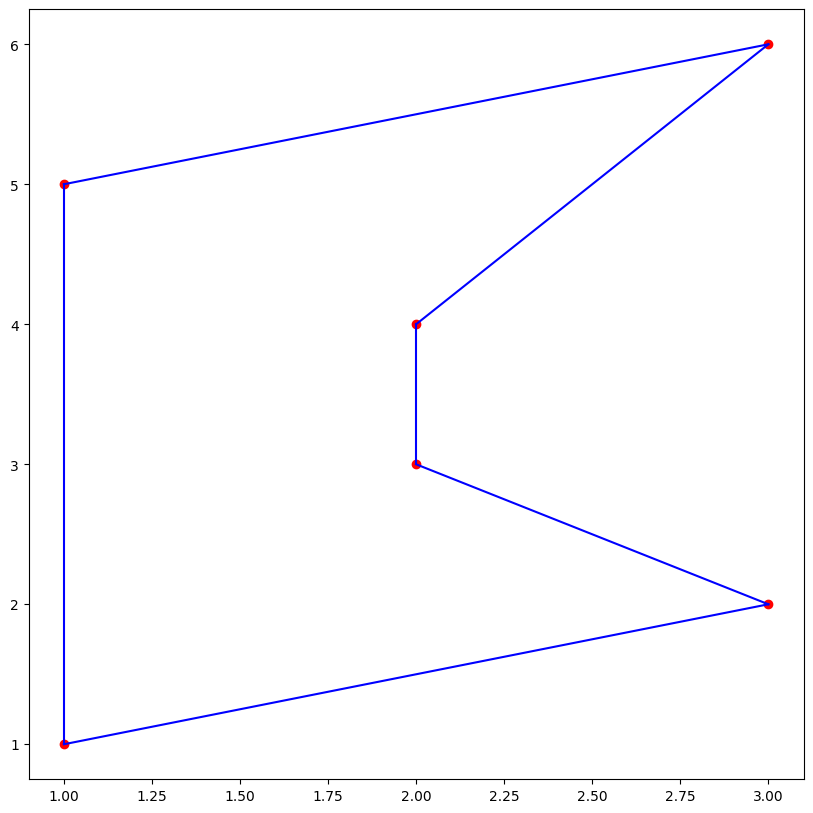

In [3]:
import numpy as np
from cqm.solver import QTSP


token = 'DEV-6dad5ce3bb8bba232cc09ef8c515e6563a2fe14e'

# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP(coordinates=coordinates, time=30, log=False)

tsp_model(token)

We saw that we can create a solver for QTSP and call it for arbitrary diagrams, well not quite. As mentioned before, theoretically we can apply this to any diagram, but practically that becomes exponentially more expensive, so the size of problems we can effectively solve is very small. This would mean that the implementation, though providing Quantum advantage, is only applicable to trivial problems, which in the industry would deem it as useless. This is why we are going to take this implementation one step further, and make it more practical.

We start by explaining the Gavish-Graves (GG) subtour elmination constraint [2]. A large class of extended ATSP formulations is known as commodity flow formulations, where the additional variables represent commodity flows through the arcs and satisfy additional flow conservation constraints. These models belong to three classes: single-commodity flow (SCF), two-commodity flow (TCF), and multi-commodity flow (MCF) formulations. The earliest SCF formulation is due to Gavish and Graves. The additional continuous non-negative variables zij describe a single commodity’s flow vertex 1 from every other vertex. The GG formulation for a single commodity problem that has sub-tour elimination constraints in it is

$∑_{j=1} z_{ij} - ∑_{j≠1} z_{ij} = 1$               $i = 2,…,n$   (1)

$z_{ij} ≤ (n - 1) y_{ij}$,        $i = 2,…,n$   and   $j = 1,…,n$   (2)

$z_{ij} ≥ 0$    for all   $i, j$   (3)

In this formulation, z is a positive variable. yij is a binary variable and is equal to 1 when the nodes of i,j are visited. Constraint (7) ensures that the flow variable ($Z_{ij}$) exists between nodes with one unit following. Constraint (8) assures that a flow is possible when the nodes are connected ($y_{ij} = 1$).

In [5]:
import os

from dimod.serialization.format import Formatter

from collections.abc import Iterable
import re
os.chdir('..')

import dwave
from dimod import ConstrainedQuadraticModel, Binary, quicksum
import numpy as np
import itertools
from matplotlib import pyplot as plt

print("All packages imported successfully!")

All packages imported successfully!


In [8]:
# Function to check if a string has a number in it
def containsNumber(value):
    num_list = []
    for character in value:
        if character.isdigit():
            num_list.append(int(character) - 1)
    return num_list

# Function to generate the subsets of a list given size
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

# Function for calculating the euclidean distance
def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

In [9]:
from cqm.data import Graph

# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

x_vals = coordinates[:, 0]
y_vals = coordinates[:, 1]

# Define graph
graph = Graph(coordinates=coordinates)

# Number of nodes
n = graph.num_nodes

# Distance Matrix
distance_matrix = graph.calculate_distance_matrix()

In [10]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

In [11]:
# Initializing the decision var
X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

In [12]:
# Defining objective (note we are iterating over n-1, as we don't have X_ij where i=j)
objective = quicksum(distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
cqm.set_objective(objective)

In [13]:
for i in range(n):
    constraint_1 = quicksum(X[i][j] for j in range(n))
    cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i+1))

In [14]:
for j in range(n):
    constraint_2 = quicksum(X[i][j] for i in range(n))
    cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j+1))

Here is where we implement the GG method. The GG method requires three constraints, namely (1), (2) and (3). We start by creating the continuous variables.


In [15]:
from dimod import Real

# Initializing the decision var
Z = np.array([[Real(f"Z_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

print(Z)

[[0
  QuadraticModel({'Z_1_2': 1.0}, {}, 0.0, {'Z_1_2': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_3': 1.0}, {}, 0.0, {'Z_1_3': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_4': 1.0}, {}, 0.0, {'Z_1_4': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_5': 1.0}, {}, 0.0, {'Z_1_5': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_1_6': 1.0}, {}, 0.0, {'Z_1_6': 'REAL'}, dtype='float64')]
 [QuadraticModel({'Z_2_1': 1.0}, {}, 0.0, {'Z_2_1': 'REAL'}, dtype='float64')
  0
  QuadraticModel({'Z_2_3': 1.0}, {}, 0.0, {'Z_2_3': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_2_4': 1.0}, {}, 0.0, {'Z_2_4': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_2_5': 1.0}, {}, 0.0, {'Z_2_5': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_2_6': 1.0}, {}, 0.0, {'Z_2_6': 'REAL'}, dtype='float64')]
 [QuadraticModel({'Z_3_1': 1.0}, {}, 0.0, {'Z_3_1': 'REAL'}, dtype='float64')
  QuadraticModel({'Z_3_2': 1.0}, {}, 0.0, {'Z_3_2': 'REAL'}, dtype='float64')
  0
  QuadraticModel({'Z_3_4': 1.0}, {}, 0.0, {'Z_3_4'

In [16]:
for i in range(n):
    if i >= 1:
        constraint_3 = quicksum(Z[i][j] for j in range(n)) - quicksum(Z[j][i] for j in range(n) if j != 0)
        cqm.add_constraint(constraint_3 == 1, label="Constraint 3-" + str(i+1))

In [17]:
for i in range(n):
    for j in range(n):
        if i != 0:
            if X[i][j] == 0:
                pass
            else:
                constraint_4 = Z[i][j] - (n-1) * X[i][j]
                cqm.add_constraint(constraint_4, sense="<=", rhs=0, label=f"Constraint 4-{i+1}{j+1}")

In [18]:
from cqm import CQMBackend


# Running the sampler to get the sample set
cqm_sampler = CQMBackend(token=token, time=30, label='CQM-TSP')
sampleset = cqm_sampler(problem=cqm)

In [22]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

Constraint 1-1 X_1_2 + X_1_3 + X_1_4 + X_1_5 + X_1_6 == 1.0
Constraint 1-2 X_2_1 + X_2_3 + X_2_4 + X_2_5 + X_2_6 == 1.0
Constraint 1-3 X_3_1 + X_3_2 + X_3_4 + X_3_5 + X_3_6 == 1.0
Constraint 1-4 X_4_1 + X_4_2 + X_4_3 + X_4_5 + X_4_6 == 1.0
Constraint 1-5 X_5_1 + X_5_2 + X_5_3 + X_5_4 + X_5_6 == 1.0
Constraint 1-6 X_6_1 + X_6_2 + X_6_3 + X_6_4 + X_6_5 == 1.0
Constraint 2-1 X_2_1 + X_3_1 + X_4_1 + X_5_1 + X_6_1 == 1.0
Constraint 2-2 X_1_2 + X_3_2 + X_4_2 + X_5_2 + X_6_2 == 1.0
Constraint 2-3 X_1_3 + X_2_3 + X_4_3 + X_5_3 + X_6_3 == 1.0
Constraint 2-4 X_1_4 + X_2_4 + X_3_4 + X_5_4 + X_6_4 == 1.0
Constraint 2-5 X_1_5 + X_2_5 + X_3_5 + X_4_5 + X_6_5 == 1.0
Constraint 2-6 X_1_6 + X_2_6 + X_3_6 + X_4_6 + X_5_6 == 1.0
Constraint 3-2 Z_2_1 + Z_2_3 + Z_2_4 + Z_2_5 + Z_2_6 - Z_3_2 - Z_4_2 - Z_5_2 - Z_6_2 == 1.0
Constraint 3-3 Z_3_1 + Z_3_2 + Z_3_4 + Z_3_5 + Z_3_6 - Z_2_3 - Z_4_3 - Z_5_3 - Z_6_3 == 1.0
Constraint 3-4 Z_4_1 + Z_4_2 + Z_4_3 + Z_4_5 + Z_4_6 - Z_2_4 - Z_3_4 - Z_5_4 - Z_6_4 == 1.0
Cons

AttributeError: module 'dimod' has no attribute 'SampleSet'

In [23]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

Constraint 1-1 0.0
Constraint 1-2 0.0
Constraint 1-3 0.0
Constraint 1-4 0.0
Constraint 1-5 0.0
Constraint 1-6 0.0
Constraint 2-1 0.0
Constraint 2-2 0.0
Constraint 2-3 0.0
Constraint 2-4 0.0
Constraint 2-5 0.0
Constraint 2-6 0.0
Constraint 3-2 0.0
Constraint 3-3 0.0
Constraint 3-4 0.0
Constraint 3-5 0.0
Constraint 3-6 0.0
Constraint 4-21 0.0
Constraint 4-23 0.0
Constraint 4-24 -4.0
Constraint 4-25 0.0
Constraint 4-26 0.0
Constraint 4-31 0.0
Constraint 4-32 0.0
Constraint 4-34 0.0
Constraint 4-35 0.0
Constraint 4-36 0.0
Constraint 4-41 0.0
Constraint 4-42 0.0
Constraint 4-43 0.0
Constraint 4-45 -3.0
Constraint 4-46 0.0
Constraint 4-51 0.0
Constraint 4-52 0.0
Constraint 4-53 0.0
Constraint 4-54 0.0
Constraint 4-56 -2.0
Constraint 4-61 0.0
Constraint 4-62 0.0
Constraint 4-63 -1.0
Constraint 4-64 0.0
Constraint 4-65 0.0


In [24]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : -4.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 0.0
sense  : Sens

In [25]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_1_2', 'X_2_4', 'X_3_1', 'X_4_5', 'X_5_6', 'X_6_3', 'Z_2_4']


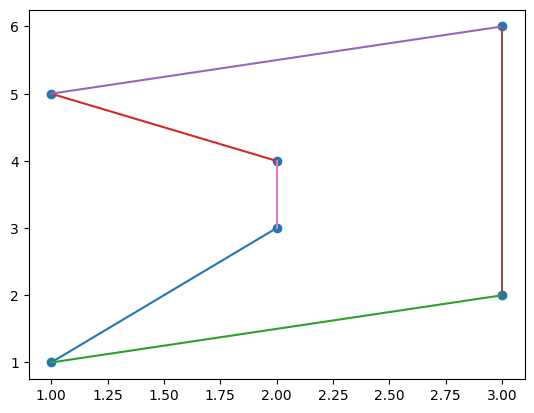

In [26]:
sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

We can see we have the same optimal result, but this time with only 30 constraints, instead of 56. Though this may not seem like a drastic change, as we increase the number of nodes, we will see this difference. Before we present the calculator for comparing the two approaches, let us package this into a class. 

In [30]:
from __future__ import annotations

__all__ = ['QTSP_Improved']

import re
import os
os.chdir('..')

import dimod
from dimod.serialization.format import Formatter
from dimod import ConstrainedQuadraticModel, Binary, quicksum, Real

from cqm.data import Graph
from cqm.solver import CQM
from cqm.backend import CQMBackend

import numpy as np


class QTSP_Improved(CQM):
    """ `QTSP_Improved` is a class for implementing a CQM for the Travelling Salesman Problem using
        Gavish-Graves subtour elimination constraint.
    """
    def __init__(self,
                 coordinates: list[list[float]],
                 time: int,
                 log: bool = True) -> None:
        """ Initializes a `QTSP` model.

        Parameters
        ----------
        `coordinates` (list[list[float]]):
            The coordinates of the nodes of the graph.
        `time` (int):
            The time limit for the problem.
        `log` (bool):
            Whether to log the output or not.
        """
        self.graph = Graph(coordinates=coordinates)
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_CQM(self) -> dimod.ConstrainedQuadraticModel:
        """ Function to define the CQM for the given graph.

        Returns
        -------
        `cqm` (dimod.ConstrainedQuadraticModel):
            The CQM.
        """
        # Define the number of nodes
        n = self.graph.num_nodes

        # Construct the distance matrix
        distance_matrix = self.graph.calculate_distance_matrix()

        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0
        constraint_3 = 0

        # Initialize the decision var
        X = np.array([[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])
        Z = np.array([[Real(f"Z_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)])

        # Define objective
        objective = quicksum(distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
        cqm.set_objective(objective)

        # Define Constraints (Only one entry and exit per node)
        for i in range(n):
            constraint_1 = quicksum(X[i][j] for j in range(n))
            cqm.add_constraint(constraint_1 == 1, label=f"Constraint 1-{i+1}")

        for j in range(n):
            constraint_2 = quicksum(X[i][j] for i in range(n))
            cqm.add_constraint(constraint_2 == 1, label=f"Constraint 2-{j+1}")

        # Define subtour elimination constraint
        for i in range(n):
            if i >= 1:
                constraint_3 = quicksum(Z[i][j] for j in range(n)) - quicksum(Z[j][i] for j in range(n) if j != 0)
                cqm.add_constraint(constraint_3 == 1, label=f"Constraint 3-{i+1}")

        for i in range(n):
            for j in range(n):
                if i != 0:
                    if X[i][j] == 0:
                        pass
                    else:
                        constraint_4 = Z[i][j] - (n-1) * X[i][j]
                        cqm.add_constraint(constraint_4, sense="<=", rhs=0, label=f"Constraint 4-{i+1}{j+1}")

        # Return the cqm
        return cqm

    def __call__(self,
                 token: str) -> None:
        """ Solves the improved QTSP.

        Parameters
        ----------
        `token` (str):
            The token for the solver.
        """
        # Define the sampler
        cqm_sampler = CQMBackend(token=token,
                                 time=self.time_limit,
                                 label='CQM-TSP')

        # Run the sampler to get the sample set
        sampleset = cqm_sampler(problem=self.cqm)

        # If the log is active, print the constraints' data
        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        # Filter the feasible samples
        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        # Get the first sample
        sample = feasible_sampleset.first.sample

        # If the log is active, print the sample
        if self.log:
            # Use `Formatter` for better readability
            Formatter(width=1000).fprint(feasible_sampleset)

            # Print the constraints' data
            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            # Print the constraints' data
            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        # Get the sample's solution
        sample_solutions = [key for key, value in sample.items() if value == 1]

        # If the log is active, print the sample's solution
        if self.log:
            print(sample_solutions)

        def containsNumber(value) -> list[int]:
            """ Checks if value contains a number and
            returns a list of numbers in the value.

            Parameters
            ----------
            `value` (str):
                The string to check.

            Returns
            -------
            `num_list` (list[int]):
                The list of numbers in the value.
            """
            # Find the numbers from the string
            return [(int(num)-1) for num in re.findall(r'\d+', value)]

        # Get the sample's coordinate sequence
        sample_coordinate_sequence = [containsNumber(solution) for solution in sample_solutions]

        # Update the graph
        self.graph.set_edges(sample_coordinate_sequence)

        # Plot the graph
        self.graph.plot()

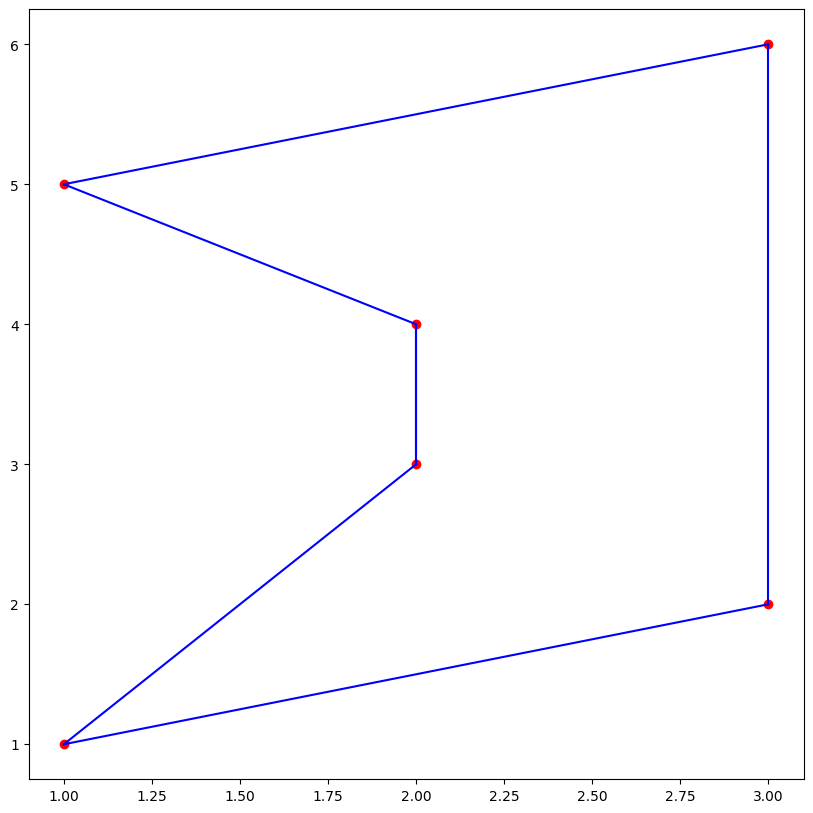

In [31]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP_Improved(coordinates=coordinates, time=30, log=False)

tsp_model(token=token)

Something to note is that we no longer need the subtour generation method, which saves us a great amount of computation. Now we have an improved solver which scales polymonially to solve TSP using Quantum Annealers. Below, you can play with the number of nodes to see the overall number of constraints required for each approach!

In [32]:
import ipywidgets as widgets
from IPython.display import display

def number_constraints(N: int) -> int:
    """
    Returns the number of constraints for a QUBO formulation of the
    Travelling Salesman Problem with N cities.
    """
    return 2**N + N - 2, (N - 1) * (N + 1) + 2 * N

# Define the interactive widget function
def interactive_number_constraints():
    N_widget = widgets.IntSlider(
        value=5,
        min=2,
        max=15,
        step=1,
        description='Number of Cities (N):',
        style={'description_width': 'initial'}
    )

    dfj_widget = widgets.Label()
    gg_widget = widgets.Label()

    def update_result(change):
        N = N_widget.value
        dfj_constraints, gg_constraints = number_constraints(N)
        dfj_widget.value = f"Number of Constraints to implement TSP with DFJ: {dfj_constraints}"
        gg_widget.value = f"Number of Constraints to implement TSP with GG: {gg_constraints}"

    N_widget.observe(update_result, 'value')

    update_result(None)  # Initial update of the result widget

    # Display the widgets
    display(N_widget, dfj_widget)
    display(gg_widget)

# Call the interactive widget function to show it in the Jupyter Notebook
interactive_number_constraints()

IntSlider(value=5, description='Number of Cities (N):', max=15, min=2, style=SliderStyle(description_width='in…

Label(value='Number of Constraints to implement TSP with DFJ: 35')

Label(value='Number of Constraints to implement TSP with GG: 34')

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

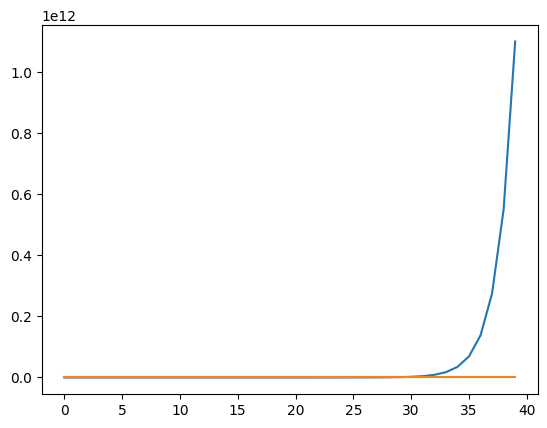

In [33]:
nodes = 40

plt.plot(range(nodes), [2**N + N - 2 for N in range(1, nodes+1)])
plt.plot(range(nodes), [(N - 1) * (N + 1) + 2*N for N in range(1, nodes+1)])

plt.plot

As we can see, the difference is quite drastic as we pass the threshold of 10 nodes (note the number of constraints is represented with 1e12). In the next and final notebook on QTSP, we will implement an application using this. The next notebook will not be focusing on QTSP's algorithm aspects, and instead will look into classical mapping of real-world maps to distance matrices, and providing different distance measures given the scale of the map.

## References

[1] : Bazrafshan, R.; Hashemkhani Zolfani, S.; Al-e-hashem, S.M.J.M. Comparison of the Sub-Tour Elimination Methods for the Asymmetric Traveling Salesman Problem Applying the SECA Method. Axioms 2021, 10, 19. https://doi.org/10.3390/axioms10010019

[2] : Gavish, B.; Graves, S. The Travelling Salesman Problem and Related Problems; Massachusetts Institute of Technology, Operations Research Center: Cambridge, MA, USA, 1978; p. 78.

<br>

<p>© 2024 Amirali Malekani Nezhad, all rights reserved.</p>